In [1]:
# Import methods

%run Methods.ipynb

In [2]:
# Old LMO

area = np.pi
thickness = 90

path = r'C:\Users\lopezb41\OneDrive - imec\Documents\Experiments\Data\Electrochemical\2023\LESK32\SCE_mimic\Full lithiation'
file = [os.path.join(path, i) for i in os.listdir(path)][0]
df1 = pd.read_csv(file, sep = ';')
df1['Corrected Time'] = df1['Time (s)'] - df1['Time (s)'][0]
df1 = df1.rename(columns = {'WE(1).Current (A)' : col_cv[1],
                          'Time (s)' : 'time',
                          'Corrected Time' : 'Time (s)',
                          'WE(1).Potential (V)' : col_cv[0]})

df1['Current Density (µA/cm$^2$)'] = df1[col_cv[1]] / area



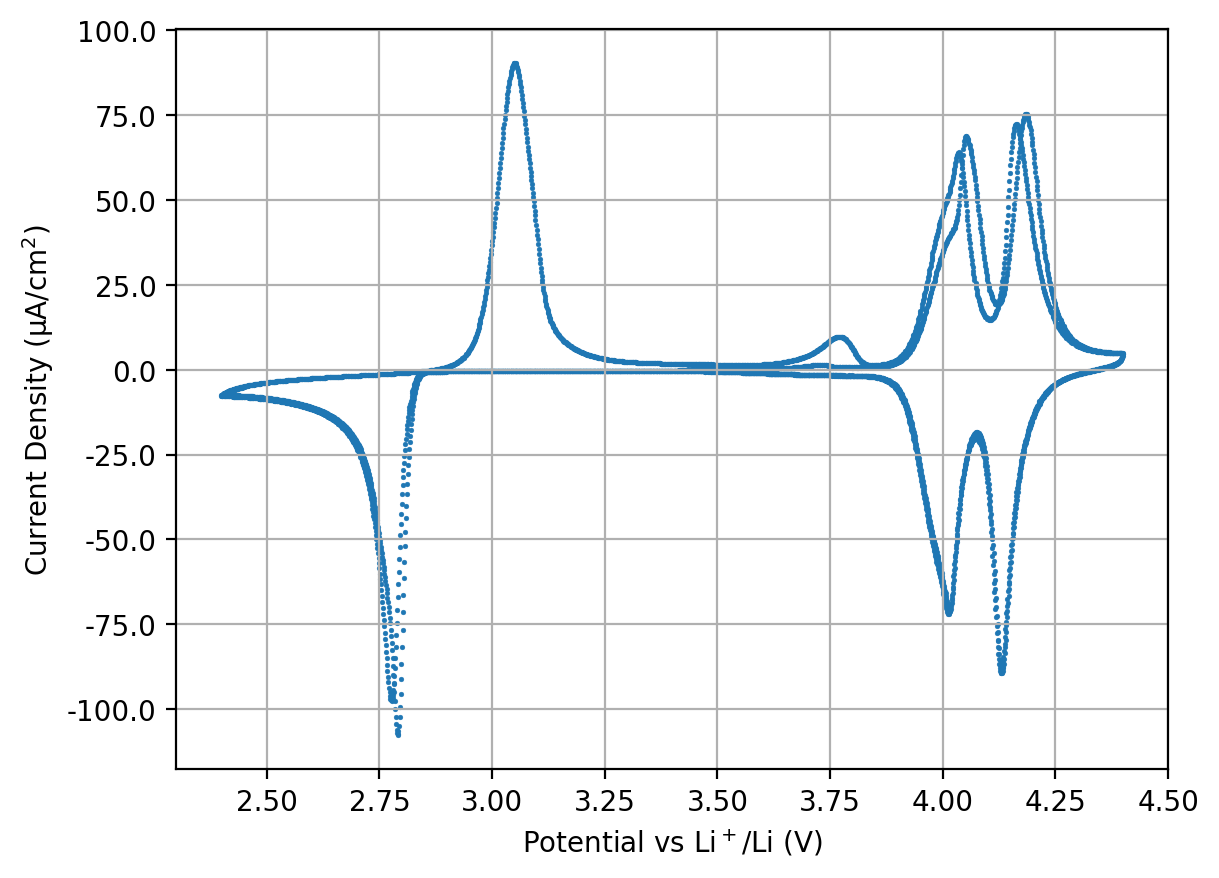

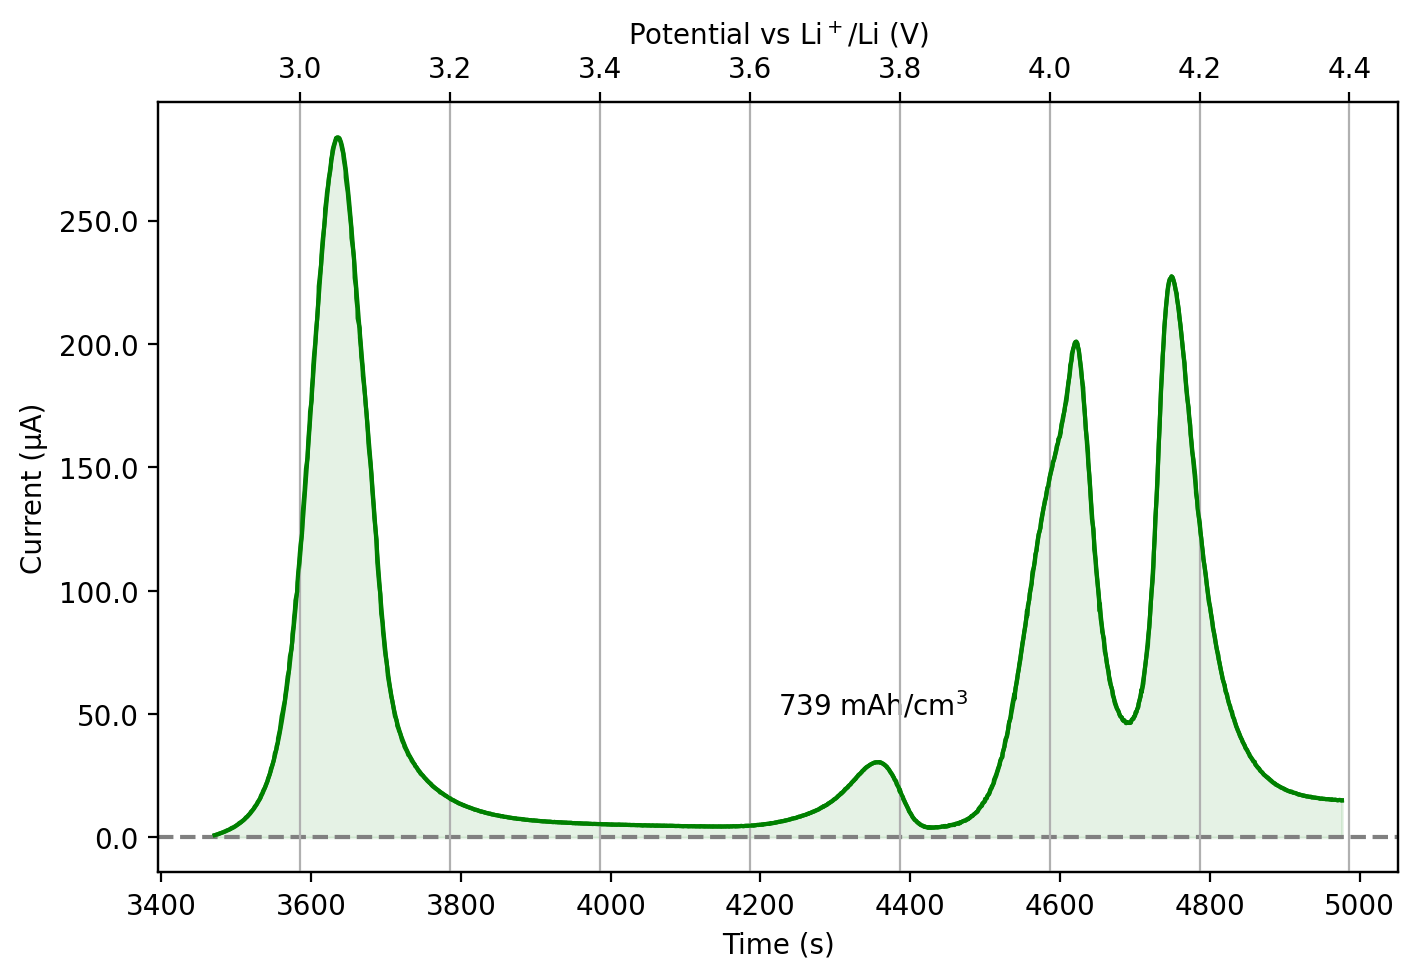

In [6]:
###### PLOT Old LMO

dpi = 200
fig, ax = plt.subplots(dpi = dpi)
sns.scatterplot(x = df1[col_cv[0]], y = df1['Current Density (µA/cm$^2$)'], edgecolor = None, s = 3) #, color = 'tab:green')
ax.yaxis.set_major_formatter(formatter_1e6)
ax.grid()
color = 'green'
capacity_cv(df1, dpi, area, thickness, 3250, 4660, True)
# charge_cv(df1, dpi,  3250, 4660, True)
# capacity_cv(df1, dpi, area, thickness, 4730, 6520, True)
# charge_cv(df1, dpi, 4730, 6520, True)

In [4]:
### New LMO

area = np.pi
thickness = 90

path = r'C:\Users\lopezb41\OneDrive - imec\Documents\Experiments\Data\Electrochemical\2024\24LSB01\STD_CV\CV'
file = [os.path.join(path, i) for i in os.listdir(path)][0]
df_n = pd.read_csv(file, sep = ';')
df_n['Corrected Time'] = df_n['Time (s)'] - df_n['Time (s)'][0]
df_n = df_n.rename(columns = {'WE(1).Current (A)' : col_cv[1],
                          'Time (s)' : 'time',
                          'Corrected Time' : 'Time(s)',
                          'WE(1).Potential (V)' : col_cv[0]})

df_n['Current Density (µA/cm$^2$)'] = df_n[col_cv[1]] / area

# dpi = 100

# scan = []

# for i in df_n['Scan'].unique():
#     df = df_n[df_n['Scan'] == i]
#     scan.append(df)




# for i in scan:
#     fig, ax = plt.subplots()
#     sns.scatterplot(x = i[col_cv[0]], y = i['Current Density (µA/cm$^2$)'], edgecolor = None, s = 3)
#     ax.yaxis.set_major_formatter(formatter_1e6)


# fig, ax = plt.subplots(dpi = dpi)
# sns.scatterplot(data = df_n, x = col_cv[0], y = 'Current Density (µA/cm$^2$)', hue = 'Scan', edgecolor = None, s = 3) #, color = 'tab:green')
# ax.yaxis.set_major_formatter(formatter_1e6)
# ax.grid()
# df_n


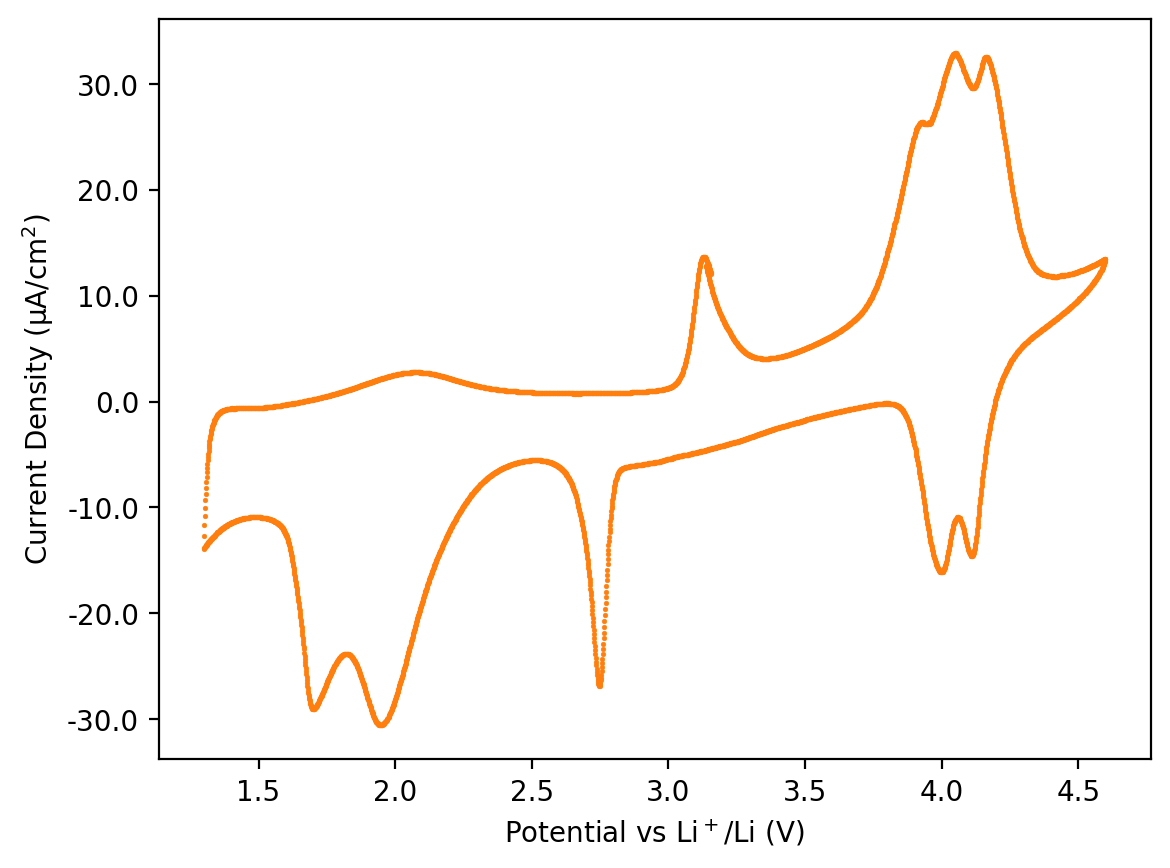

In [6]:
# TiO2 capacity from CV
#Total capacity Li2Mn2O4 1260 mAh/cm3

path = r'C:\Users\lopezb41\OneDrive - imec\Documents\Experiments\Data\Electrochemical\2023\ALD TiO2\144cycles_ext\1C\CV'
cv_path = [os.path.join(path, i) for i in os.listdir(path)]
area = np.pi
thickness = 90

df = pd.read_csv(cv_path[0], sep = ';')
df['Corrected Time'] = df['Time (s)'] - df['Time (s)'][0]
df = df.rename(columns = {'WE(1).Current (A)' : col_cv[1],
                          'Time (s)' : 'time',
                          'Corrected Time' : 'Time (s)',
                          'WE(1).Potential (V)' : col_cv[0]})
df['Current Density (µA/cm$^2$)'] = df[col_cv[1]] / area

dpi = 200
ca = 6500
cb = 12700
fig, ax = plt.subplots(dpi = dpi)
sns.scatterplot(x = df[col_cv[0]][ca:cb], y = df['Current Density (µA/cm$^2$)'][ca:cb], edgecolor = None, s = 3, color = 'tab:orange')
ax.yaxis.set_major_formatter(formatter_1e6)

# ax.grid()
# charge_cv(df, dpi, 10, 1600, True)
# charge_cv(df, dpi, 10, 2070, False)

# charge_cv(df, dpi, 2070, 3750, True)
# charge_cv(df, dpi, 2070, 4780, True)
# charge_cv(df, dpi, 5020, 6100, False)
# charge_cv(df, dpi, 6200, 7780, True)
# charge_cv(df, dpi, 5100, 7780, True)

# capacity_cv(df, dpi, area, 9, 5020, 6000, False)
# plt.xlim(1.55, 2.75)
